In [2]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations
import seaborn as sns
import copy
import itertools

import tensorflow as tf
import tensorflow_lattice as tfl
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import keras.ops as ops
from tensorflow.keras.models import clone_model
import keras_tuner as kt
from keras import regularizers
from keras.utils import plot_model
from tensorflow.keras.losses import Poisson
from tensorflow.keras.losses import Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras import backend as K
from scipy.stats import gamma


from pygam import LinearGAM, GAM, s, f, l
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import DecisionTreeRegressor
from interpret.glassbox import ExplainableBoostingClassifier

In [3]:
#-------------------------- for reproducibility --------------------------
seed_value = 2024
keras.utils.set_random_seed(seed_value)

In [4]:
#-------------------------- import data --------------------------
dt_low = pd.read_csv("synthetic_low_var.csv") # low variance of response
dt_high = pd.read_csv("synthetic_high_var.csv") # high variance of response
dt_low.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,99.774917
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,1265.079807
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,303.794567
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,55.925713
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,25.417815


In [5]:
#-------------------------- remove outliers - low variance --------------------------
log_claim = np.log(dt_low['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_low_cleaned = dt_low[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_low_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,99.774917
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,1265.079807
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,303.794567
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,55.925713
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,25.417815
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,0,-0.906239,0.044427,4,0.539039,0.823778,0.218616,126.191598
19996,-0.403467,0.989823,-0.239838,0,-0.264332,-0.555279,1,-0.841188,-0.964766,-0.498512,410.914315
19997,-0.107088,0.176448,-0.661992,0,0.900670,0.995538,2,0.667651,-0.428700,0.324157,867.243736
19998,-0.279747,-0.150770,-0.472139,1,0.639225,0.127594,3,0.545812,0.189384,-0.602032,441.187979


In [6]:
#-------------------------- remove outliers - high variance --------------------------
log_claim = np.log(dt_high['Y'])
IQR = log_claim.quantile(0.75) - log_claim.quantile(0.25) # inter-quartile range
lower_whisker = log_claim.quantile(0.25)- 1.5*IQR
upper_whisker = log_claim.quantile(0.75) + 1.5*IQR

# remove outliers: filter rows where the log of 'Y' is within the whiskers
dt_high_cleaned = dt_high[(log_claim >= lower_whisker) & (log_claim <= upper_whisker)]
dt_high_cleaned

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Y
0,0.097627,-0.215654,-0.261487,1,-0.174621,-0.793202,5,-0.373985,0.790363,0.014048,14.079968
1,0.430379,-0.917687,-0.577348,2,0.878463,-0.924689,5,-0.133907,0.381623,-0.808513,2214.413643
2,0.205527,0.846601,-0.046190,1,-0.309264,-0.659747,4,0.196131,0.513124,0.212212,2.394700
3,0.089766,-0.187530,-0.835531,0,-0.931951,0.781547,1,-0.763961,0.067880,-0.162218,0.897459
4,-0.152690,0.888564,-0.524681,1,0.045908,-0.395223,6,-0.910878,-0.748679,-0.801435,37.343106
...,...,...,...,...,...,...,...,...,...,...,...
19995,0.496349,0.336766,0.766494,0,-0.906239,0.044427,4,0.539039,0.823778,0.218616,48.799725
19996,-0.403467,0.989823,-0.239838,0,-0.264332,-0.555279,1,-0.841188,-0.964766,-0.498512,23444.511569
19997,-0.107088,0.176448,-0.661992,0,0.900670,0.995538,2,0.667651,-0.428700,0.324157,181.741108
19998,-0.279747,-0.150770,-0.472139,1,0.639225,0.127594,3,0.545812,0.189384,-0.602032,32.257254


In [7]:
#-------------------------- column lists --------------------------
target_var = "Y" # target feature
all_vars = list(dt_low_cleaned.columns)
all_vars.remove(target_var) # store all input features
cat_vars = ["X4", "X7"] # categorical features

In [8]:
############################ 1. MODEL FITTING ############################

#-------------------------- train-test split --------------------------
# low variance
X_main_low, X_test_low, y_main_low, y_test_low = train_test_split(
    dt_low_cleaned[all_vars], dt_low_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train_low, X_val_low, y_train_low, y_val_low = train_test_split(
    X_main_low, y_main_low, test_size = 0.25, random_state = 1)

# high variance
X_main_high , X_test_high , y_main_high , y_test_high  = train_test_split(
    dt_high_cleaned[all_vars], dt_high_cleaned[["Y"]], test_size = 0.2, random_state = 1)
X_train_high , X_val_high , y_train_high , y_val_high  = train_test_split(
    X_main_high , y_main_high , test_size = 0.25, random_state = 1)

In [9]:
# -------------------------- function to create a subnetwork --------------------------
# Layer to center a subnetwork's outputs to zero mean
@keras.saving.register_keras_serializable()
class ZeroCenter(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, inputs):
        mean = ops.mean(inputs, axis = 0, keepdims = True)
        return inputs - mean

# subnet for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(ZeroCenter()) # zero center all output
    return model

In [10]:
# -------------------------- define model architecture --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 10
num_layers_main = 2
activation = 'leaky_relu'

# main effect
for name in all_vars:
    # Input layers
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train_low[name].nunique(), 
                                output_dim = 1, 
                                name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"reshape_{name}")(embed_layer)
        cat_dense = ZeroCenter(name = f"dense_{name}")(embed_layer_reshape)
        switcher_layer = Dense(1, use_bias = False, 
                                kernel_initializer = Constant(1),
                                trainable = False, 
                                name = f"{name}_switcher_layer")(cat_dense)
        sub_outputs_main.append(switcher_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        switcher_layer = Dense(1, use_bias = False, 
                                kernel_initializer = Constant(1),
                                trainable = False, 
                                name = f"{name}_switcher_layer")(sub_output)
        sub_outputs_main.append(switcher_layer)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
final_output = Dense(1, activation = 'exponential',
                     name = "main_output")(main_subnets)

# final model
model_low = Model(inputs = inputs, outputs = final_output)

In [11]:
# -------------------------- define loss function --------------------------
# we will use a Gamma loss function
def gamma_log_likelihood(y_true, y_pred):
    y_pred = keras.ops.clip(y_pred, 1e-7, 1e30)
    return keras.ops.mean(y_true/y_pred - keras.ops.log(y_true/y_pred))

# create training & validation data consistent with the model architecture
X_train_low_split = []
X_val_low_split = []
X_test_low_split = []
for i in range(len(X_train_low.columns)):
    X_train_low_split.append(X_train_low.iloc[:, i])
    X_val_low_split.append(X_val_low.iloc[:, i])
    X_test_low_split.append(X_test_low.iloc[:, i])

# compile and fit
model_low.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main = model_low.fit(X_train_low_split, y_train_low, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))

Epoch 1/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 881.5150 - root_mean_squared_error: 2848.7371 - val_loss: 775.5844 - val_root_mean_squared_error: 2518.4351
Epoch 2/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 813.1348 - root_mean_squared_error: 2848.7129 - val_loss: 736.1038 - val_root_mean_squared_error: 2518.4141
Epoch 3/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 770.2436 - root_mean_squared_error: 2848.6914 - val_loss: 704.2773 - val_root_mean_squared_error: 2518.3916
Epoch 4/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 734.9469 - root_mean_squared_error: 2848.6682 - val_loss: 676.8629 - val_root_mean_squared_error: 2518.3665
Epoch 5/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 704.5742 - root_mean_squared_error: 2848.6431 - val_loss: 653.2488 - val_root_mean_squared_error: 2518.3403
Epoch 6/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 678.5765 - root_mean_squared_error: 2848.6165 - val_loss: 633.0356 - val_root_mean_squared_error: 2

In [12]:
# -------------------------- get validation loss --------------------------
main_val_loss, main_rmse = model_low.evaluate(X_val_low_split, y_val_low, verbose = False, batch_size = X_val_low_split[0].shape[0]) # get the validation loss and RMSE
print(f"Validation loss for main effect: {main_val_loss}")
print(f"Validation RMSE for main effect: {main_rmse}")

Validation loss for main effect: 2.491867780685425
Validation RMSE for main effect: 2284.679443359375


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


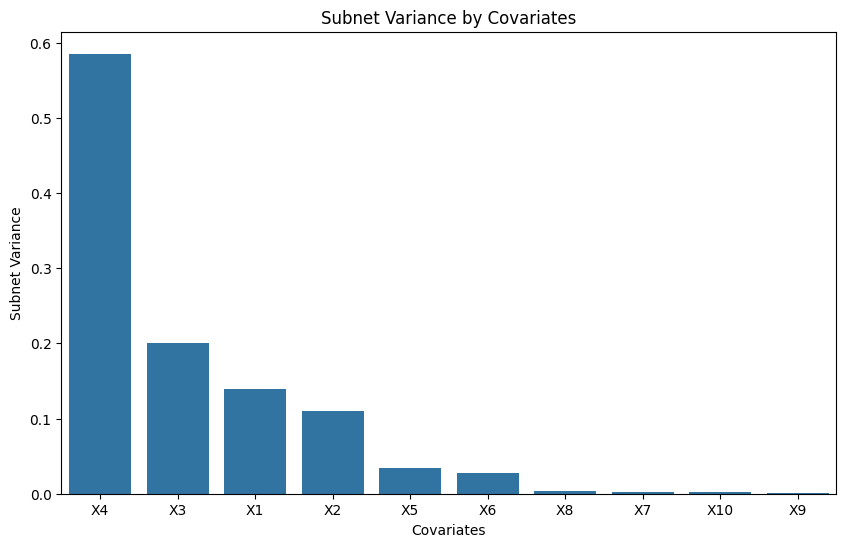

In [13]:
# -------------------------- quantify variable importance --------------------------
main_output_layer = model_low.get_layer("main_subnet")  # Get the subnet output layer
main_model = Model(inputs = model_low.inputs, outputs = main_output_layer.output)
main_output_values = main_model.predict(X_train_low_split, batch_size = X_train_low_split[0].shape[0])
subnet_weights = model_low.get_layer("main_output").get_weights()[0]


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(main_output_values.shape[1]):
    subnet_variance.append(np.var(main_output_values[:, i])*subnet_weights[i][0]**2)

# Define covariates
covariates = [name for name in all_vars]

# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

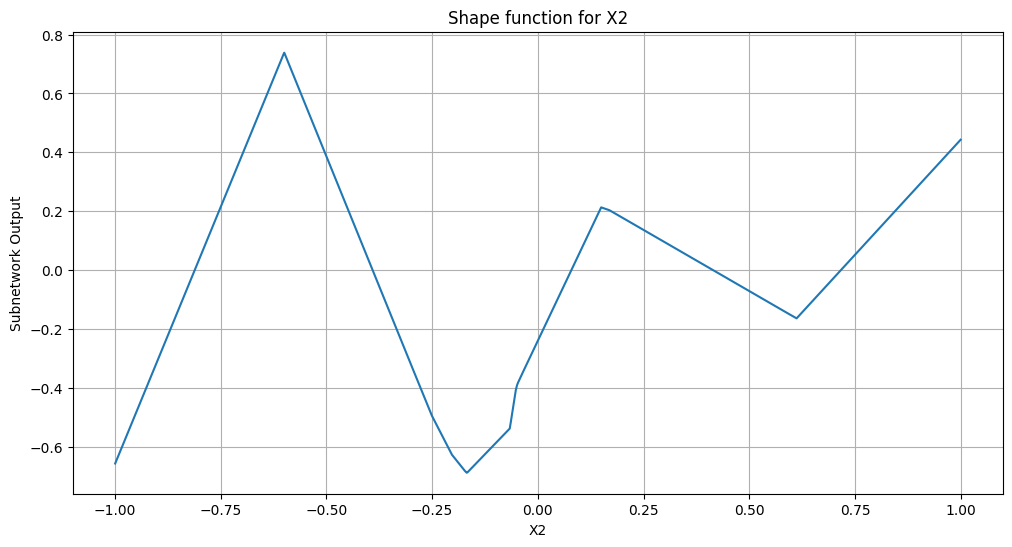

In [14]:
#-------------------------- view the shape function --------------------------
# create the plot
var_name = "X2"
var_index = all_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_low_split[var_index], 
             y = main_output_values[:,var_index].flatten()*subnet_weights[var_index][0])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [15]:
############################   select interaction effect   ############################
global_layers = ["main_subnet", "main_output", "interaction_output", "final_output"] # these layers are always trainable
interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
imp_vars = [f"X{i}" for i in range(1,7)] # important variables
interactions = combinations(imp_vars, 2)
num_layers_interaction = 3 # number of layers for each interaction effect
num_neurons_interaction = 50 # number of neurons per dense layer for each interaction effect


# add pairwise effect and evaluate validation loss
for var1, var2 in interactions:

    # -------------------------- initialize a cloned model --------------------------
    model_main_cloned = clone_model(model_low) # clone the main effect model
    model_main_cloned.build(model_low.input_shape)
    model_main_cloned.set_weights(model_low.get_weights()) # copy the weights

    # -------------------------- build a subnet for pairwise interaction effect --------------------------
    var1_input = model_main_cloned.inputs[all_vars.index(var1)]
    var2_input = model_main_cloned.inputs[all_vars.index(var2)]
    pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
    pairwise_subnet = create_subnet(num_layers_interaction, 
                                    num_neurons_interaction, 
                                    activation, 
                                    f"{var1}_{var2}_subnetwork")
    pairwise_dense = pairwise_subnet(pairwise_input_layer)
    interaction_subnet_output = Dense(1, activation = 'exponential',
                        name = "interaction_output")(pairwise_dense)
    main_subnet_output = model_main_cloned.output
    final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
    model_pairwise = Model(inputs = model_main_cloned.inputs, outputs = final_output)

    # -------------------------- switch on/off layers --------------------------
    for layer in model_pairwise.layers:
        if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
            layer.trainable = False
    
    # -------------------------- compile and train the model --------------------------
    model_pairwise.compile(optimizer = RMSprop(), loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
    es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
    model_pairwise.fit(X_train_low_split, y_train_low, epochs = 5_000, \
                            callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))
    val_loss, _ = model_pairwise.evaluate(X_val_low_split, y_val_low, batch_size = X_val_low_split[0].shape[0])
    interaction_loss[f"{var1}_{var2}"] = val_loss # add to the val loss list

Epoch 1/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.3884 - root_mean_squared_error: 2535.1541 - val_loss: 2.4780 - val_root_mean_squared_error: 2279.4717
Epoch 2/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3817 - root_mean_squared_error: 2531.2690 - val_loss: 2.4772 - val_root_mean_squared_error: 2281.0388
Epoch 3/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3808 - root_mean_squared_error: 2530.1729 - val_loss: 2.4772 - val_root_mean_squared_error: 2282.3457
Epoch 4/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3804 - root_mean_squared_error: 2529.9202 - val_loss: 2.4770 - val_root_mean_squared_error: 2282.5532
Epoch 5/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3800 - root_mean_squared_error: 2529.4368 - val_loss: 2.4770 - val_root_mean_squared_error: 2282.9446
Epoch 6/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3799 - root_mean_squared_error: 2529.4387 - val_loss: 2.4768 - val_root_mean_squared_error: 2282.9346
Epoch 7/5000
12

In [16]:
# for layer in model_main_cloned.layers:
#     print(f"{layer.name}    {layer.trainable}")
# # print(model_pairwise.get_layer("X8_switcher_layer").get_weights())

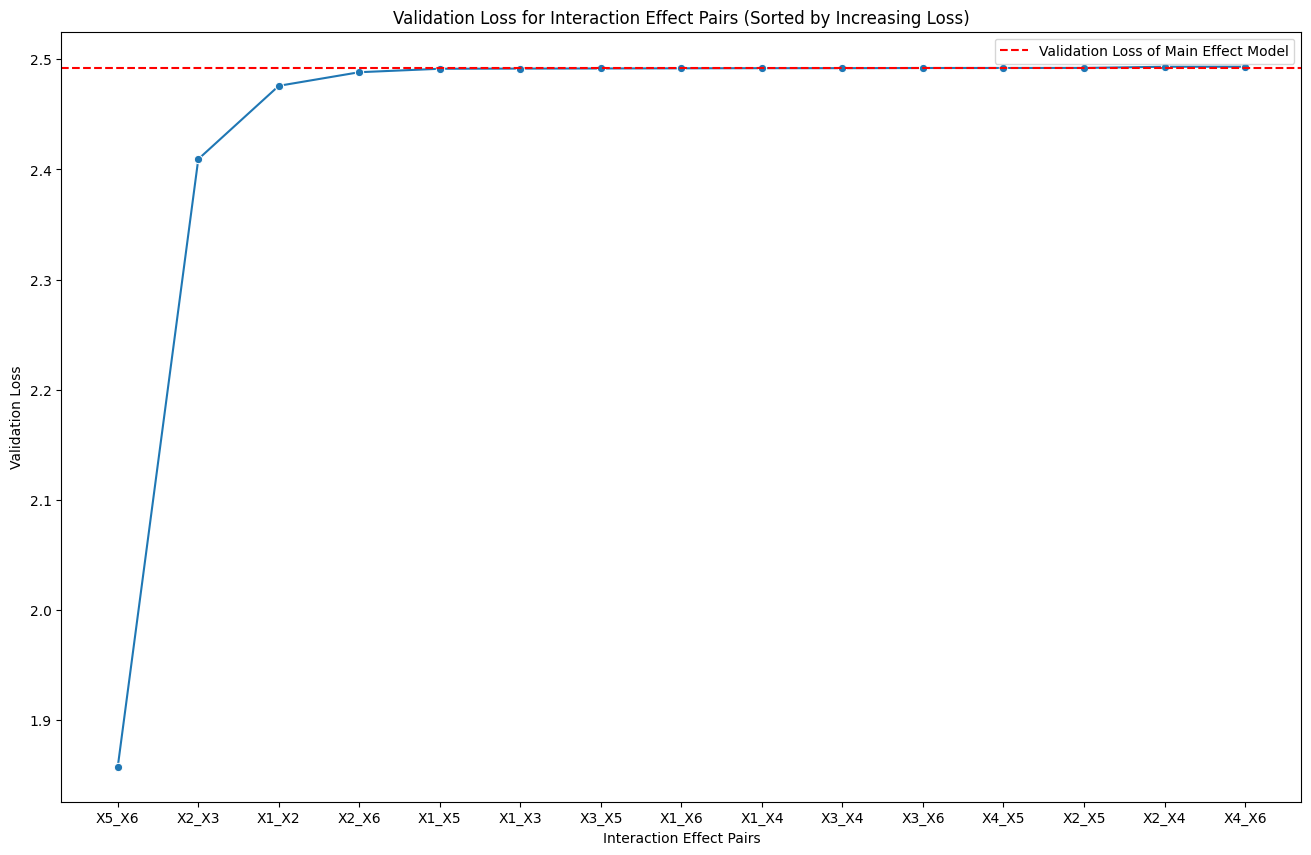

In [17]:
# -------------------------- plot the validation loss --------------------------
# Convert interaction loss dictionary to a pandas DataFrame
interaction_df = pd.DataFrame(list(interaction_loss.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

# Sort the DataFrame by Validation_Loss in increasing order
interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)

# Create the bar plot using Seaborn
plt.figure(figsize = (16, 10))
sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
plt.axhline(main_val_loss, color = 'red', linestyle = '--', label = 'Validation Loss of Main Effect Model')
plt.xlabel('Interaction Effect Pairs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Interaction Effect Pairs (Sorted by Increasing Loss)')
plt.legend()
plt.show()

In [18]:
# -------------------------- define model architecture --------------------------
imp_interactions = [("X5","X6"),("X2","X3"),("X1","X2")]
inputs = []  # input layers
sub_outputs = [] # subnet output
num_neurons_main = 30
num_layers_main = 3
num_neurons_interaction = 100
num_layers_interaction = 5
activation = 'leaky_relu'

# main effect
for name in imp_vars:
    
    # Input layers
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train_low[name].nunique(), 
                                output_dim = 1, 
                                name = f"embed_{name}")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"reshape_{name}")(embed_layer)
        cat_output = ZeroCenter(name = f"{name}_dense")(embed_layer_reshape)
        sub_outputs.append(cat_output)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs.append(sub_output)

# pairwise interaction effect
for (var1, var2) in imp_interactions:
    var1_input = inputs[imp_vars.index(var1)]
    var2_input = inputs[imp_vars.index(var2)]
    pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
    pairwise_subnet = create_subnet(num_layers_interaction, 
                                    num_neurons_interaction, 
                                    activation, 
                                    f"{var1}_{var2}_subnetwork")
    pairwise_dense = pairwise_subnet(pairwise_input_layer)
    sub_outputs.append(pairwise_dense)
    

# combine subnets' outputs
subnets = Concatenate(name = "subnet_output")(sub_outputs)
output_layer = Dense(1, activation = 'exponential',
                     name = "final_output")(subnets)

# final model
model_main_pairwise = Model(inputs = inputs, outputs = output_layer)

In [19]:
# -------------------------- compile and fit --------------------------
# remove irrelevant main effects
X_train_important = []
X_val_important = []
X_test_important = []
for i in range(len(X_train_low_split)):
    if all_vars[i] in imp_vars:
        X_train_important.append(X_train_low_split[i])
        X_val_important.append(X_val_low_split[i])
        X_test_important.append(X_test_low_split[i])

model_main_pairwise.compile(optimizer = RMSprop(), loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
es = EarlyStopping(restore_best_weights = True, patience = 10)
%time hist_main_pairwise = model_main_pairwise.fit(X_train_important, y_train_low, epochs = 5_000, \
    callbacks = [es], batch_size = 1_000, validation_data = (X_val_important, y_val_low))

Epoch 1/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 831.2495 - root_mean_squared_error: 2848.7148 - val_loss: 710.9667 - val_root_mean_squared_error: 2518.3582
Epoch 2/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 734.7534 - root_mean_squared_error: 2848.6184 - val_loss: 663.1834 - val_root_mean_squared_error: 2518.3054
Epoch 3/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 675.9757 - root_mean_squared_error: 2848.5547 - val_loss: 614.6502 - val_root_mean_squared_error: 2518.2405
Epoch 4/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 616.0846 - root_mean_squared_error: 2848.4714 - val_loss: 567.3147 - val_root_mean_squared_error: 2518.1389
Epoch 5/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 560.7842 - root_mean_squared_error: 2848.3665 - val_loss: 514.4802 - val_root_mean_squared_error: 2517.9924
Epoch 6/5000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 509.4440 - root_mean_squared_error: 2848.2302 - val_loss: 463.6220 - val_root_mean_squared_error: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


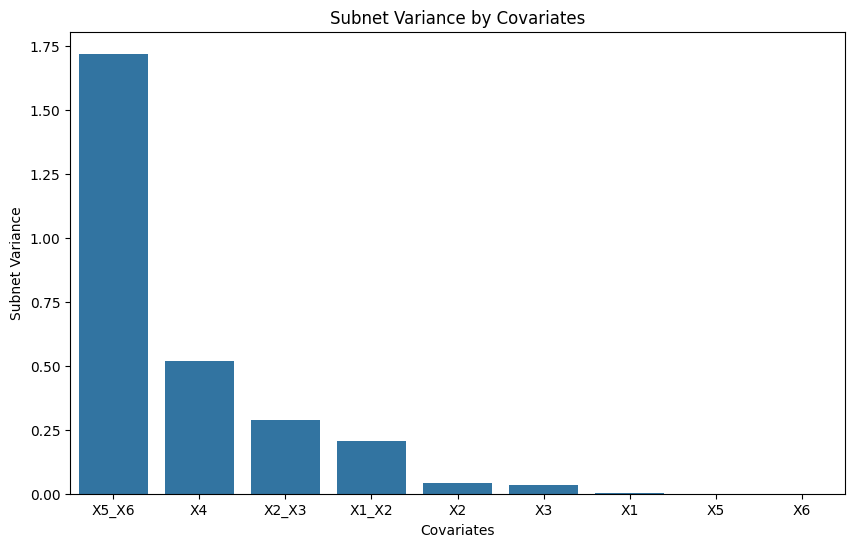

In [20]:
# -------------------------- quantify variable importance --------------------------
subnet_layer = model_main_pairwise.get_layer("subnet_output")
subnet_output_model = Model(inputs = model_main_pairwise.inputs, 
                            outputs = subnet_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_important, batch_size = X_train_important[0].shape[0])
weights = model_main_pairwise.get_layer("final_output").get_weights()[0]


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    subnet_variance.append(np.var(subnet_output_values[:, i])*weights[i][0]**2)

# Define covariates
covariates = [name for name in imp_vars]
for i in range(len(imp_interactions)):
    covariates.append(f"{imp_interactions[i][0]}_{imp_interactions[i][1]}")


# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


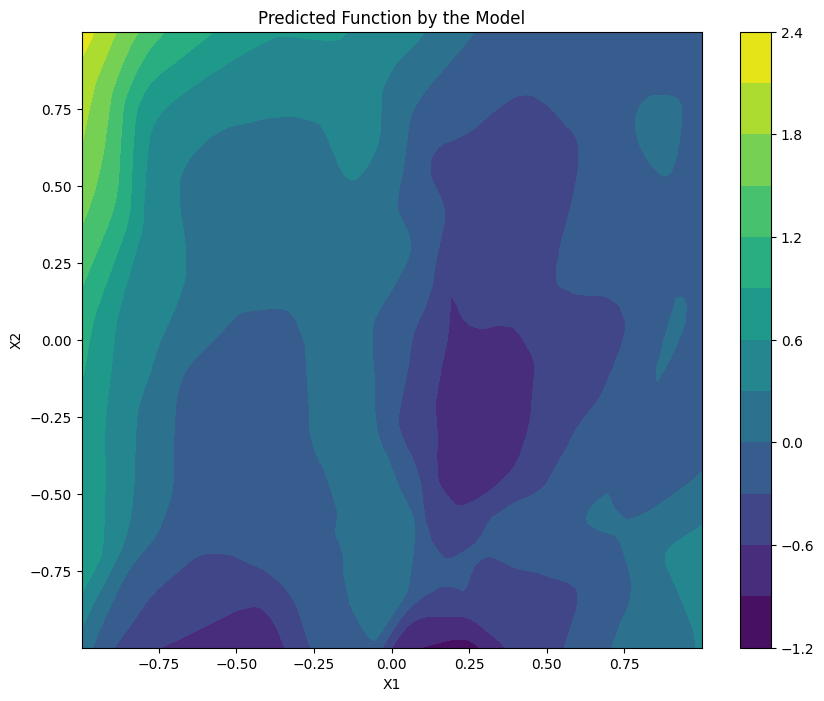

In [21]:
# -------------------------- Create the Pairwise Only Model --------------------------
pairwise_effect = ("X1","X2")  # the pairwise effect we want to view
pairwise_index = imp_interactions.index(pairwise_effect)
subnet_output_layer = model_main_pairwise.get_layer("subnet_output")
subnet_model = Model(inputs = model_main_pairwise.inputs, outputs = subnet_output_layer.output)
weights = model_main_pairwise.get_layer("final_output").get_weights()[0]


# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
var1_values = np.linspace(X_train_low[imp_interactions[pairwise_index][0]].min(), 
                          X_train_low[imp_interactions[pairwise_index][0]].max(), 
                          grid_length)
var2_values = np.linspace(X_train_low[imp_interactions[pairwise_index][1]].min(), 
                          X_train_low[imp_interactions[pairwise_index][1]].max(), 
                          grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in imp_vars:
    if var == imp_interactions[pairwise_index][0]:
        grid_inputs.append(grid_flat_var1)
    elif var == imp_interactions[pairwise_index][1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = subnet_model.predict(grid_inputs, batch_size = grid_length**2)[:,len(imp_vars) + pairwise_index]*weights[len(imp_vars) + pairwise_index]

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{imp_interactions[pairwise_index][0]}")
plt.ylabel(f"{imp_interactions[pairwise_index][1]}")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


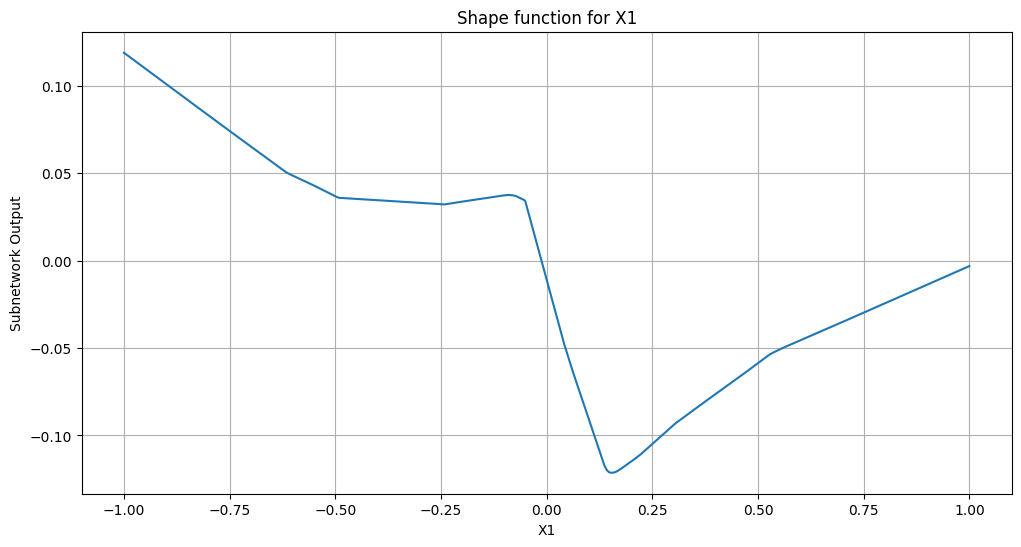

In [30]:
#-------------------------- view the shape function --------------------------
# get the prediction
subnet_output = subnet_model.predict(X_train_important, batch_size = X_train_important[0].shape[0])

# create the plot
var_name = "X1"
var_index = imp_vars.index(var_name)
plt.figure(figsize = (12, 6))
sns.lineplot(x = X_train_important[var_index], 
             y = subnet_output[:,var_index]*weights[var_index])
plt.xlabel(f"{var_name}")
plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [23]:
# # -------------------------- Create the Pairwise Only Model --------------------------
# pairwise_index = 0 # the pairwise effect we want to view
# pairwise_output_layer = model_pairwise.get_layer("interaction_output")
# pairwise_only_model = Model(inputs = model_pairwise.inputs, outputs = pairwise_output_layer.output)

# # -------------------------- Generate the Input Grid --------------------------
# # Create a grid of values
# var1_values = np.linspace(X_train_low[imp_interactions[pairwise_index][0]].min(), 
#                           X_train_low[imp_interactions[pairwise_index][0]].max(), 
#                           100)
# var2_values = np.linspace(X_train_low[imp_interactions[pairwise_index][1]].min(), 
#                           X_train_low[imp_interactions[pairwise_index][1]].max(), 
#                           100)

# # Create a meshgrid
# grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# # Flatten the grid
# grid_flat_var1 = grid_var1.ravel()
# grid_flat_var2 = grid_var2.ravel()


# # -------------------------- Prepare Inputs for the Model --------------------------
# # Create zero arrays for the other variables
# other_vars_zero = np.zeros((len(grid_flat_var1), len(all_vars) - 2))
# grid_inputs = []
# for var in all_vars:
#     if var == imp_interactions[pairwise_index][0]:
#         grid_inputs.append(grid_flat_var1)
#     elif var == imp_interactions[pairwise_index][1]:
#         grid_inputs.append(grid_flat_var2)
#     else:
#         grid_inputs.append(np.zeros_like(grid_flat_var1))

# # Convert to the format expected by the model
# grid_inputs = [grid_inputs[all_vars.index(var)] for var in all_vars]


# # -------------------------- Predict Using the Pairwise-Only Model --------------------------
# # Predict the pairwise interaction effect
# pairwise_predictions = pairwise_only_model.predict(grid_inputs)[:,pairwise_index]

# # Reshape the predictions to the grid format
# heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# # -------------------------- Plot the Heatmap --------------------------
# plt.figure(figsize = (10, 8))
# contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
# plt.colorbar(contour)
# plt.title('Predicted Function by the Model')
# plt.xlabel(f"{imp_interactions[pairwise_index][0]}")
# plt.ylabel(f"{imp_interactions[pairwise_index][1]}")
# plt.show()

In [24]:
# # -------------------------- define model architecture --------------------------
# inputs = []  # input layers
# sub_outputs_main = []  # main effect subnet output
# sub_outputs_interaction = []  # interaction effect subnet output
# num_neurons_main = 40
# num_layers_main = 5
# num_neurons_interaction = 200
# num_layers_interaction = 15
# activation = 'leaky_relu'

# # main effect
# for name in all_vars:
#     # Input layers
#     input_layer = Input(shape = (1,), name = name)
#     inputs.append(input_layer)

#     # subnetworks for main effects
#     if name in cat_vars: # categorical variables
#         # categorical variables will be one-hot encoded
#         embed_layer = Embedding(input_dim = X_train_low[name].nunique(), 
#                                 output_dim = 1, 
#                                 name = f"embed_{name}")(input_layer)
#         embed_layer_reshape = Reshape(target_shape = (1,), name = f"reshape_{name}")(embed_layer)
#         switcher_layer = Dense(1, use_bias = False, 
#                                 kernel_initializer = Constant(1),
#                                 trainable = False, 
#                                 name = f"{name}_switcher_layer")(embed_layer_reshape)
#         sub_outputs_main.append(switcher_layer)
#     else: # numeric variables
#         subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
#         sub_output = subnet(input_layer)
#         switcher_layer = Dense(1, use_bias = False, 
#                                 kernel_initializer = Constant(1),
#                                 trainable = False, 
#                                 name = f"{name}_switcher_layer")(sub_output)
#         sub_outputs_main.append(switcher_layer)

# # pairwise interaction effect
# for (var1, var2) in interactions:
#     var1_input = inputs[all_vars.index(var1)]
#     var2_input = inputs[all_vars.index(var2)]
#     pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
#     pairwise_subnet = create_subnet(num_layers_interaction, 
#                                     num_neurons_interaction, 
#                                     activation, 
#                                     f"{var1}_{var2}_subnetwork",
#                                     trainable = False)
#     pairwise_dense = pairwise_subnet(pairwise_input_layer)
#     switcher_layer = Dense(1, use_bias = False, 
#                                kernel_initializer = Constant(0), # the default is to switch off pairwise interaction 
#                                trainable = False, 
#                                name = f"{var1}_{var2}_switcher_layer")(pairwise_dense) # used for controlling interaction effect
#     sub_outputs_interaction.append(switcher_layer)
    

# # combine subnets' outputs
# main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
# main_subnet_output = Dense(1, activation = 'exponential',
#                      name = "main_output")(main_subnets)
# interaction_subnets = Concatenate(name = "interaction_subnet")(sub_outputs_interaction)
# interaction_subnet_output = Dense(1, activation = 'exponential',
#                      name = "interaction_output",
#                      kernel_initializer = Constant(0),
#                      bias_initializer = Constant(0),
#                      trainable = False)(interaction_subnets)
# output_layer = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])

# # final model
# model_low = Model(inputs = inputs, outputs = output_layer)

In [25]:
# ############################   select interaction effect   ############################
# global_layers = ["main_subnet", "interaction_subnet", "main_output", "interaction_output", "final_output"] # these layers are always trainable
# interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
# imp_vars = [f"X{i}" for i in range(1,7)] # important variables
# # imp_interactions = []
# # for var1, var2 in interactions:
# #     if var1 in imp_vars and var2 in imp_vars:
# #         imp_interactions.append((var1,var2))
# imp_interactions = [("X5","X6")]


# # add pairwise effect and evaluate validation loss
# for var1, var2 in imp_interactions:

#     # -------------------------- initialize a cloned model --------------------------
#     model_pairwise_test = clone_model(model_low) # clone the main effect model
#     model_pairwise_test.build(model_low.input_shape)
#     model_pairwise_test.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
#     model_pairwise_test.set_weights(model_low.get_weights()) # copy the weights

#     # switch off all non-global layers
#     for layer in model_pairwise_test.layers:
#         if layer.name not in global_layers:
#             layer.trainable = False

#     # -------------------------- activate subnetworks for relevant main/pairwise effects --------------------------
#     # var1
#     if var1 in cat_vars:
#         model_pairwise_test.get_layer(f"embed_{var1}").trainable = True
#     else:
#         model_pairwise_test.get_layer(f"{var1}_subnetwork").trainable = True
#     # var2
#     if var2 in cat_vars:
#         model_pairwise_test.get_layer(f"embed_{var2}").trainable = True
#     else:
#         model_pairwise_test.get_layer(f"{var2}_subnetwork").trainable = True
#     # pairwise
#     model_pairwise_test.get_layer(f"{var1}_{var2}_subnetwork").trainable = True

#     # switch on the pairwise effect switcher
#     switcher = model_pairwise_test.get_layer(f"{var1}_{var2}_switcher_layer")
#     current_weights = switcher.get_weights()
#     new_weights = [np.ones_like(current_weights[0])] # set to 1
#     switcher.set_weights(new_weights) # activate

#     # -------------------------- re-train the model --------------------------
#     model_pairwise_test.fit(X_train_low_split, y_train_low, epochs = 5_000, \
#         callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))
#     val_loss, _ = model_pairwise_test.evaluate(X_val_low_split, y_val_low)
#     interaction_loss[f"{var1}_{var2}"] = val_loss # add to the val loss list

In [26]:
# #-------------------------- train the interaction effect --------------------------
# global_layers = ["main_subnet", "interaction_subnet", "main_output", "interaction_output", "final_output"]# these layers are always trainable

# # switch off irrelevant layers
# for layer in model_low.layers:
#     if layer.name not in global_layers and interactions[0][0] not in layer.name and interactions[0][1] not in layer.name:
#     # if layer.name not in global_layers and "switcher_layer" not in layer.name:
#         layer.trainable = False
# # model_low.get_layer(f"{interactions[0][0]}_{interactions[0][1]}_subnetwork").trainable = True

# # activate the switcher layer
# switcher = model_low.get_layer(f"{interactions[0][0]}_{interactions[0][1]}_switcher_layer")
# current_weights = switcher.get_weights()
# new_weights = [np.ones_like(current_weights[0])] # set to 1
# switcher.set_weights(new_weights)

# # re-train
# %time hist_interaction = model_low.fit(X_train_low_split, y_train_low, epochs = 5_000, \
#     callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))

In [27]:
# # -------------------------- quantify variable importance --------------------------
# main_output_layer = model_low.get_layer("main_subnet")
# interaction_output_layer = model_low.get_layer("interaction_subnet")
# subnet_output_model = Model(inputs = model_low.inputs, outputs = [main_output_layer.output, interaction_output_layer.output])
# output_values = subnet_output_model.predict(X_train_low_split)
# subnet_output_values = np.concatenate((output_values[0], output_values[1]), axis = 1)
# main_weights = model_low.get_layer("main_output").get_weights()[0]
# interaction_weights = model_low.get_layer("interaction_output").get_weights()[0]
# subnet_weights = np.concatenate((main_weights, interaction_weights), axis = 0)

# # Get the variance of each subnetwork across all data points
# subnet_variance = []
# for i in range(subnet_output_values.shape[1]):
#     subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)

# # Define covariates
# covariates = [name for name in all_vars]
# for i in range(len(interactions)):
#     covariates.append(f"{interactions[i][0]}_{interactions[i][1]}")


# # -------------------------- plot the variable importance --------------------------
# # Create DataFrame for variable importance
# var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# # Sort the DataFrame by subnet variance in decreasing order
# varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# # Create a bar plot using Seaborn
# plt.figure(figsize = (10, 6))
# sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
# plt.title("Subnet Variance by Covariates")
# plt.xlabel("Covariates")
# plt.ylabel("Subnet Variance")
# plt.show()

In [28]:
# # Create a new model with only the pairwise subnetwork as output
# pairwise_output_layer = model_low.get_layer("interaction_output")
# pairwise_only_model = Model(inputs = model_low.inputs, outputs = pairwise_output_layer.output)
# weights = model_low.get_layer("interaction_output").get_weights()[0][pairwise_index]

# # Create a new model with only the pairwise subnetwork as output
# pairwise_output_layer = model_main_cloned.get_layer("interaction_output")
# pairwise_only_model = Model(inputs = model_main_cloned.inputs, outputs = pairwise_output_layer.output)
# weights = model_main_cloned.get_layer("interaction_output").get_weights()[0][pairwise_index]

In [29]:
# imp_interactions = [("X2","X3")]
# imp_vars = [f"X{i}" for i in range(1,7)] # important variables
# num_neurons_interaction = 100
# num_layers_interaction = 5
# global_layers = ["main_subnet", "interaction_subnet", "main_output", "interaction_output", "final_output"]


# for var1, var2 in imp_interactions:
#     # -------------------------- build a subnet for pairwise interaction effect --------------------------
#     var1_input = model_low.inputs[all_vars.index(var1)]
#     var2_input = model_low.inputs[all_vars.index(var2)]
#     pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
#     pairwise_subnet = create_subnet(num_layers_interaction, 
#                                     num_neurons_interaction, 
#                                     activation, 
#                                     f"{var1}_{var2}_subnetwork")
#     pairwise_dense = pairwise_subnet(pairwise_input_layer)
#     interaction_subnet_output = Dense(1, activation = 'exponential',
#                         name = "interaction_output")(pairwise_dense)
#     main_subnet_output = model_low.output
#     final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
#     model_pairwise = Model(inputs = model_low.inputs, outputs = final_output)

#     # -------------------------- switch on/off layers --------------------------
#     for layer in model_pairwise.layers:
#         if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
#             layer.trainable = False

#     # -------------------------- compile and train the model --------------------------
#     model_pairwise.compile(optimizer = "rmsprop", loss = gamma_log_likelihood, metrics = [RootMeanSquaredError()])
#     model_pairwise.fit(X_train_low_split, y_train_low, epochs = 5_000, \
#                             callbacks = [es], batch_size = 1_000, validation_data = (X_val_low_split, y_val_low))